> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from personalization parameters (the decoder used in the co-adaptation algorithm). Thus, implement a basic ML model to link the decoder matrices back to the corresponding subject.  

- 14 Subjects, therefore random guessing would be 7.14% correct on average

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *
from experiment_params import *

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
import warnings
warnings.filterwarnings("ignore")

random.seed(a=1)

# Load In Data

In [2]:
my_models = [LogisticRegression(), KNeighborsClassifier(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

In [3]:
#dec_flattened_df1 = pd.read_csv("C:\\Users\\kdmen\\Desktop\\Research\\Data\\dec_full_flattened_df1.csv")
#dec_flattened_df2 = pd.read_csv("C:\\Users\\kdmen\\Desktop\\Research\\Data\\dec_full_flattened_df2.csv")
dec_flattened_df1 = pd.read_csv("C:\\Users\\kdmen\\Desktop\\Research\\Data\\dec_flattened_df1.csv")
dec_flattened_df2 = pd.read_csv("C:\\Users\\kdmen\\Desktop\\Research\\Data\\dec_flattened_df2.csv")
dec_flattened_df = pd.concat((dec_flattened_df1, dec_flattened_df2))

if (dec_flattened_df.columns[0] == 'Unnamed: 0'):
    dec_flattened_df.drop(dec_flattened_df.columns[0], axis=1, inplace=True)

print(dec_flattened_df.shape)
dec_flattened_df.head(5)

(2128, 4)


,Subject,Condition,Update Number,Flattened Decoder
0,METACPHS_S106,0,0,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
1,METACPHS_S106,0,1,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
2,METACPHS_S106,0,2,[-0.34157085 0.08410593 -0.54057447 0.444319...
3,METACPHS_S106,0,3,[-0.17386248 0.00370517 0.40721562 -0.515221...
4,METACPHS_S106,0,4,[ 0.83210615 -1.32612423 0.28718983 1.302252...


In [4]:
dec_flattened_df.tail(5)

,Subject,Condition,Update Number,Flattened Decoder
1059,METACPHS_S112,7,14,[ 1.72746602e-01 -6.46751979e-01 1.08992359e+...
1060,METACPHS_S112,7,15,[-3.07344160e-02 6.03699218e-02 4.26590818e-...
1061,METACPHS_S112,7,16,[ 9.17285360e-02 1.60315698e-01 3.93406660e-...
1062,METACPHS_S112,7,17,[ 1.20744948e-01 -4.79756037e-01 2.03405148e+...
1063,METACPHS_S112,7,18,[ 0.04912337 0.06417236 2.15931676 -2.307400...


In [5]:
# SPLIT BASED ON CONDITION NUMBERS
# initialization conditions
pos_init = [0, 1, 4, 5]
neg_init = [2, 3, 6, 7]

Why was I looking at positive vs negative init effect on adversarial accuracy lol


In [6]:
pos_dec_df = dec_flattened_df[dec_flattened_df["Condition"].isin(pos_init)]
neg_dec_df = dec_flattened_df[dec_flattened_df["Condition"].isin(neg_init)]

In [7]:
pos_dec_df.head()

,Subject,Condition,Update Number,Flattened Decoder
0,METACPHS_S106,0,0,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
1,METACPHS_S106,0,1,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
2,METACPHS_S106,0,2,[-0.34157085 0.08410593 -0.54057447 0.444319...
3,METACPHS_S106,0,3,[-0.17386248 0.00370517 0.40721562 -0.515221...
4,METACPHS_S106,0,4,[ 0.83210615 -1.32612423 0.28718983 1.302252...


In [8]:
pos_dec_expanded_df = pd.DataFrame()
for my_row in range(pos_dec_df.shape[0]):
    test=pd.DataFrame(pos_dec_df.iloc[my_row,3].strip("[]").split()).T
    pos_dec_expanded_df = pd.concat((pos_dec_expanded_df, test))

pos_dec_expanded_df.reset_index(inplace=True, drop=True)
pos_dec_expanded_df.insert(loc=0, column='Update Number', value=list(pos_dec_df['Update Number']))
pos_dec_expanded_df.insert(loc=0, column='Condition', value=list(pos_dec_df['Condition']))
pos_dec_expanded_df.insert(loc=0, column='Subject', value=list(pos_dec_df['Subject']))

# Concat All 19 Update Model Results
> Should I be trying to use the same model but predicting on different datasets too?

In [9]:
def make_all_update_models(flattened_input_df, my_metrics_columns=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds'], my_models_list=[LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], make_df=True, full_test_df=pd.DataFrame()):

    if make_df:
        full_test_df = pd.DataFrame(columns=my_metrics_columns)

    for i in range(19):
        print(f"{i} of {19}")
        ith_df, ith_test_df = nth_decoder_model(flattened_input_df, i, my_models_list, test=True)

        full_test_df = pd.concat((full_test_df, ith_test_df))

    full_test_df.drop('K Folds', axis=1, inplace=True)
    full_test_df.drop('One Off Acc', axis=1, inplace=True)
    full_test_df.drop('CV Acc', axis=1, inplace=True)

    return full_test_df

In [10]:
# Setting all column names to strings, idk why this was breaking it just now
pos_dec_expanded_df.columns = pos_dec_expanded_df.columns.astype(str)

full_pos_test_df = make_all_update_models(pos_dec_expanded_df)
full_pos_test_df.head(8)

0 of 19
1 of 19
2 of 19
3 of 19
4 of 19
5 of 19
6 of 19
7 of 19
8 of 19
9 of 19
10 of 19
11 of 19
12 of 19
13 of 19
14 of 19
15 of 19
16 of 19
17 of 19
18 of 19


,Algorithm,Test Acc,N
0,LogisticRegression(),0.0,0
0,KNeighborsClassifier(),0.0,0
0,GaussianNB(),100.0,0
0,LinearSVC(),0.0,0
0,SGDClassifier(),5.882,0
0,DecisionTreeClassifier(),100.0,0
0,GradientBoostingClassifier(),100.0,0
0,LogisticRegression(),0.0,1


In [11]:
pos_lr_df = full_pos_test_df[full_pos_test_df['Algorithm']=='LogisticRegression()']
pos_knn_df = full_pos_test_df[full_pos_test_df['Algorithm']=='KNeighborsClassifier()']
pos_svc_df = full_pos_test_df[full_pos_test_df['Algorithm']=='LinearSVC()']
pos_sgd_df = full_pos_test_df[full_pos_test_df['Algorithm']=='SGDClassifier()']
pos_dt_df = full_pos_test_df[full_pos_test_df['Algorithm']=='DecisionTreeClassifier()']
pos_gbt_df = full_pos_test_df[full_pos_test_df['Algorithm']=='GradientBoostingClassifier()']

# FOR POSTER

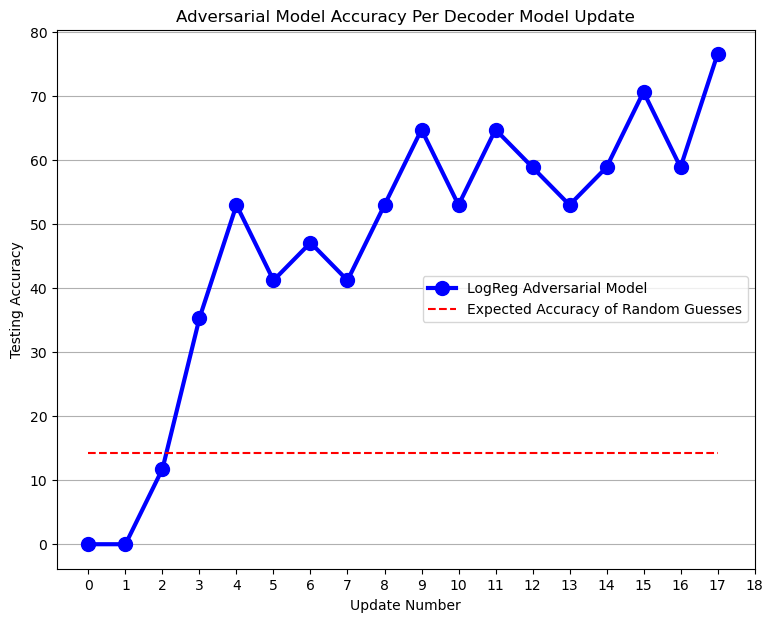

In [12]:
skip_block = 0
end_block = 18
col_num = 1
my_x_updates = list(range(end_block))[skip_block:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, pos_lr_df.iloc[skip_block:end_block, col_num], marker=".", markersize=20, color='blue', linewidth=3, label='Adversarial Linkage Model')
plt.hlines(14.29, 0, 17, color='red', linestyle='--', label='Expected Accuracy of Random Guesses')
#plt.text(x, 5, "Random Guesses", color='red') #verticalalignment='center', 
plt.xticks(np.arange(0, 19, 1.0))
#plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Adversarial Model Accuracy Per Decoder Model Update')
plt.legend(loc='center right')
plt.show()

In [ ]:
assert(1==0)

In [13]:
pos_lr_df.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\107P_lr.csv")
pos_knn_df.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\107P_knn.csv")
pos_svc_df.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\107P_svc.csv")
pos_sgd_df.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\107P_sgd.csv")
pos_dt_df.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\107P_dt.csv")
pos_gbt_df.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\107P_gbt.csv")